In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.preprocessing import StandardScaler 
from scipy.cluster.hierarchy import linkage, fcluster

In [2]:
data = pd.read_csv("COVID-19_update.csv")
data2=data
warnings.filterwarnings("ignore")
week =20;
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ZIP Code                              2280 non-null   object 
 1   Week Number                           2280 non-null   int64  
 2   Week Start                            2280 non-null   object 
 3   Week End                              2280 non-null   object 
 4   Cases - Weekly                        2105 non-null   float64
 5   Cases - Cumulative                    2105 non-null   float64
 6   Case Rate - Weekly                    2105 non-null   float64
 7   Case Rate - Cumulative                2105 non-null   float64
 8   Tests - Weekly                        2250 non-null   float64
 9   Tests - Cumulative                    2280 non-null   int64  
 10  Test Rate - Weekly                    2280 non-null   int64  
 11  Test Rate - Cumul

In [3]:
def make_predictions(train, test, p, d, q, P=0, D=0, Q=0, s=0):
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(train, order = (p, d, q), seasonal_order = (P, D, Q, s))
        fitted_model = model.fit()
        predicted = fitted_model.predict(len(train)+1, len(train)+1)
        predictions.append(predicted[-1])
        train.append(test[t])
    # Evaluate predictions
    error = mean_squared_error(test, predictions)
    corr = np.corrcoef(test, predictions)[1, 0]
    print('MSE: %.3f' % error)
    print('Correlation: %.3f' % corr)
    # Plot results
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()
    
def plotmap(data,a,b,c):
    recent = pd.DataFrame(data['cluster'])
    recent['geometry']=data['ZIP Code Location'].astype('string')
    recent.dropna(subset = ["geometry"], inplace=True)
    crs={'init': 'epsg:4326'}
    geo = gpd.GeoDataFrame(recent,crs=crs,geometry=recent['geometry'].apply(wkt.loads))
    street_map = gpd.read_file('geo_export.shp')
    fig, ax = plt.subplots(figsize = (8,8))
    street_map.plot(color='grey', ax=ax, alpha = 0.4)
    geo[geo['cluster']==a].geometry.plot(marker='o', color = 'red', ax = ax, label = 'high risk', alpha=.5, markersize = 75 )
    geo[geo['cluster']==b].geometry.plot(marker='o', color = 'yellow', ax = ax, label = 'middle risk', alpha = .5, markersize = 30)
    geo[geo['cluster']==c].geometry.plot(marker='o', color = 'green', ax = ax, label = 'low risk', alpha = .5, markersize = 30)
    plt.legend(prop={'size':15})
    
def plotlevel(clusters):
    recent["cluster"]= clusters
    ax = recent.plot(kind = 'scatter', x = 'ZIP Code', y = 'Case Rate - Weekly', c = 'cluster', colormap = plt.cm.brg)
    ax = recent.plot(kind = 'scatter', x = 'ZIP Code', y = 'Death Rate - Weekly', c = 'cluster', colormap = plt.cm.brg)
    ax = recent.plot(kind = 'scatter', x = 'ZIP Code', y = 'Case Rate - Cumulative', c = 'cluster', colormap = plt.cm.brg)

### 1. Explore Time Series for weekly case rate 

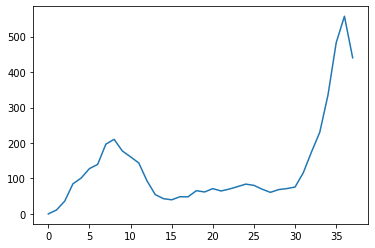

In [4]:

data = pd.pivot_table(data, index = ['Week Number']).reset_index()
CaseRate = data['Case Rate - Weekly'].fillna(0)
CaseRate.plot()

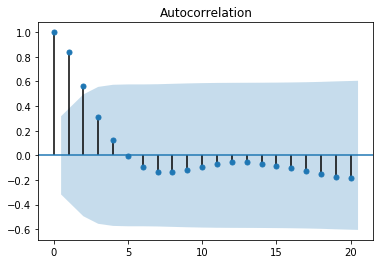

In [5]:
plot_acf(CaseRate, lags=20)
q=3
pyplot.show()

1.2 choose the order of AR part of model

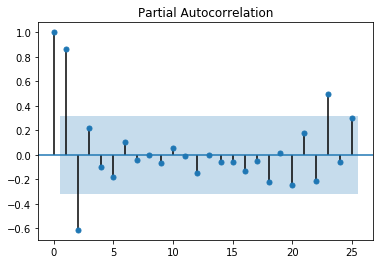

In [6]:
plot_pacf(CaseRate, lags=25)
p=3
pyplot.show()

1.3 Method: Moving Average (MA)

MSE: 14763.872
Correlation: 0.979


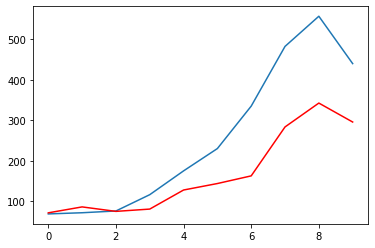

In [7]:
n_test = 10 
data_list = CaseRate.values.tolist()
train, test = data_list[0:(len(data_list)-n_test)], data_list[(len(data_list)-n_test):len(data_list)]
make_predictions(train, test, p=0, d=0, q=q, P=0, D=0, Q=0, s=0)

1.4 Method: Autoregression (AR)

MSE: 59634.641
Correlation: 0.601


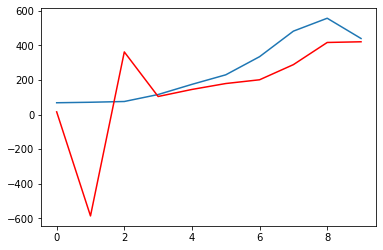

In [8]:
make_predictions(train, test, p=p, d=0, q=0, P=0, D=0, Q=0, s=0)

1.5 Method: Autoregressive Moving Average (ARMA)

MSE: 22273.676
Correlation: 0.687


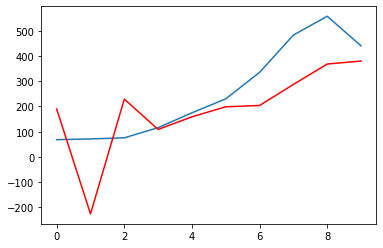

In [9]:
make_predictions(train, test, p=p, d=0, q=q, P=0, D=0, Q=0, s=0)

1.6  Autoregressive Integrated Moving Average (ARIMA)

MSE: 14204.587
Correlation: 0.790


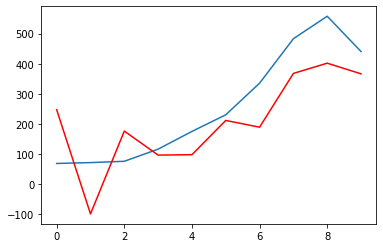

In [10]:
make_predictions(train, test, p=p, d=1, q=q, P=0, D=0, Q=0, s=0)

result:

    MSE: 14763 Correlation: 0.979  MA
    MSE: 59634 Correlation: 0.601  AR
    MSE: 22273 Correlation: 0.687  ARMA
    MSE: 14204 Correlation: 0.790  ARIMA
MA modle has much lower MSE and higher Correlation, we choose MA as our model to predict weekly case rate

Predict case rate in the next 10 weeks

In [11]:
casepredictions = list()
for t in range(week):
    model = ARIMA(data_list, order = (0, 0, q))
    fitted_model = model.fit()
    predicted = fitted_model.predict(t+1, t+1)
    casepredictions.append(predicted[-1])
    train.append(predicted)

### 2. Explore Time Series for weekly death rate 

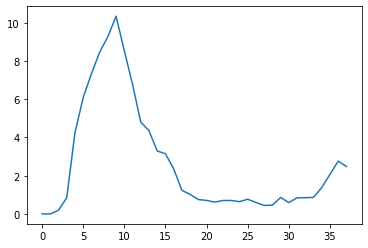

In [12]:
DeathRate = data['Death Rate - Weekly']
DeathRate = DeathRate.squeeze()
DeathRate.plot()

2.1 choose the order of MA part of model

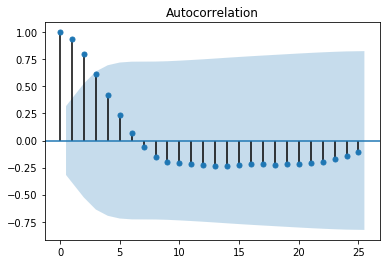

In [13]:
plot_acf(DeathRate, lags=25)
q=3
pyplot.show()

2.2 choose the order of AR part of model

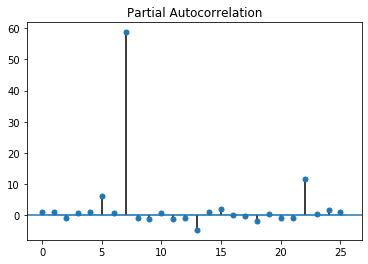

In [14]:
plot_pacf(DeathRate, lags=25)
p=1
pyplot.show()

2.3 Method: Moving Average (MA)

In [15]:
n_test = 10 
data_list = DeathRate.values.tolist()
train, test = data_list[0:(len(data_list)-n_test)], data_list[(len(data_list)-n_test):len(data_list)]

MSE: 1.164
Correlation: 0.506


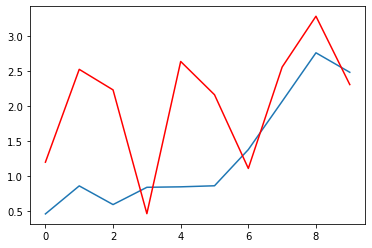

In [16]:
make_predictions(train, test, p=0, d=0, q=q, P=0, D=0, Q=0, s=0)

2.4 Method: Autoregression (AR)

MSE: 0.524
Correlation: 0.531


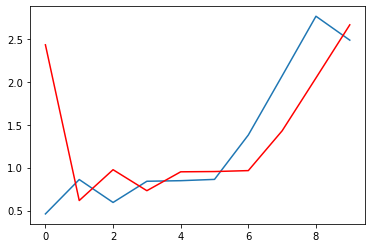

In [17]:
make_predictions(train, test, p=p, d=0, q=0, P=0, D=0, Q=0, s=0)

2.5 Method: Autoregressive Moving Average (ARMA)

MSE: 0.831
Correlation: 0.571


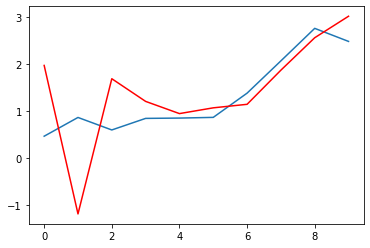

In [18]:
make_predictions(train, test, p=p, d=0, q=q, P=0, D=0, Q=0, s=0)

2.6 Autoregressive Integrated Moving Average (ARIMA)

MSE: 0.737
Correlation: 0.582


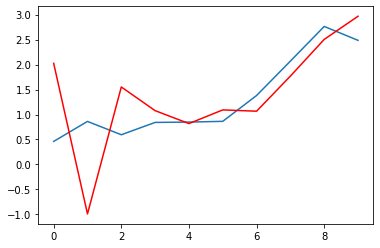

In [19]:
make_predictions(train, test, p=p, d=1, q=q, P=0, D=0, Q=0, s=0)

result:

       MSE: 1.164 Correlation: 0.506 MA
       MSE: 0.524 Correlation: 0.531 AR
       MSE: 0.831 Correlation: 0.571 ARMA
       MSE: 0.737 Correlation: 0.582 ARIMA
Since they have similar correlation ratio, but AR modle has much lower MSE, we choose AR as our model to predict weekly death rate

Predict death rate in the next 10 weeks

In [20]:
deathpredictions = list()
for t in range(week):
    model = ARIMA(data_list, order = (p, 0, q))
    fitted_model = model.fit()
    predicted = fitted_model.predict(t+1, t+1)
    deathpredictions.append(predicted[-1])
    train.append(predicted)

### 3. Explore Time Series for Cumulative case rate 

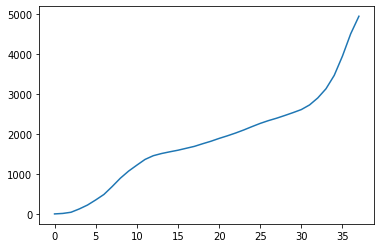

In [21]:
Case = data['Case Rate - Cumulative'].fillna(0)
Case = Case.squeeze()
Case.plot()

3.1 choose the order of MA part of model

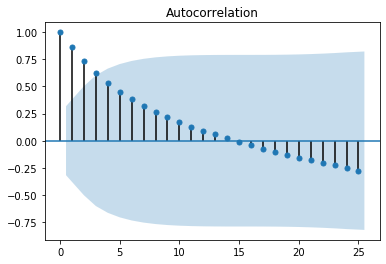

In [22]:
plot_acf(Case, lags=25)
q=4
pyplot.show()

3.2 choose the order of AR part of model

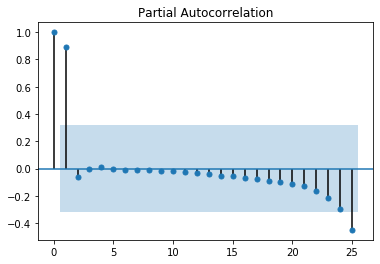

In [23]:
plot_pacf(Case, lags=25)
p=2
pyplot.show()

In [24]:
n_test = 10 
data_list = Case.values.tolist()
train, test = data_list[0:(len(data_list)-n_test)], data_list[(len(data_list)-n_test):len(data_list)]

3.3 Method: Moving Average (MA)

MSE: 395562.959
Correlation: 0.994


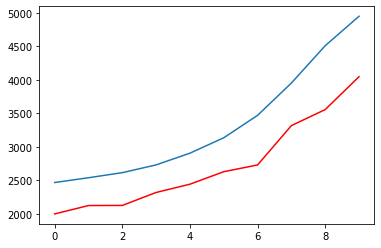

In [25]:
make_predictions(train, test, p=0, d=0, q=q, P=0, D=0, Q=0, s=0)

3.4 Method: Autoregression (AR)

MSE: 1727847.501
Correlation: 0.353


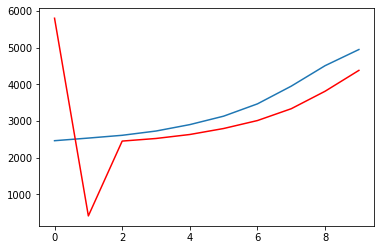

In [26]:
make_predictions(train, test, p=p, d=0, q=0, P=0, D=0, Q=0, s=0)

3.5 Autoregressive Moving Average (ARMA)

MSE: 778487.691
Correlation: 0.390


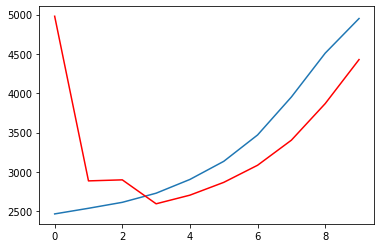

In [27]:
make_predictions(train, test, p=p, d=1, q=0, P=0, D=0, Q=0, s=0)

3.6 Autoregressive Integrated Moving Average (ARIMA)

MSE: 522733.571
Correlation: 0.559


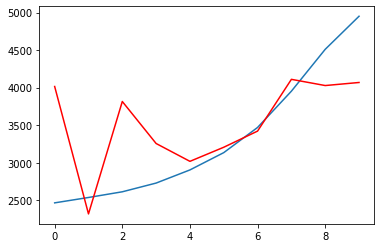

In [28]:
make_predictions(train, test, p=p, d=1, q=q, P=0, D=0, Q=0, s=0)

result:
 
    MSE: 395562 Correlation: 0.994 MA
    MSE: 1727847 Correlation: 0.353 AR
    MSE: 778487 Correlation: 0.390 ARMA
    MSE: 522733 Correlation: 0.559 ARIMA
MA modle has much lower MSE and higher Correlation, we choose MA as our model to predict cumulative case rate

Predict Cumulative case rate in the next 10 weeks

In [29]:
cumupredictions = list()
for t in range(week):
    model = ARIMA(data_list, order = (0, 0, q))
    fitted_model = model.fit()
    predicted = fitted_model.predict(t+1, t+1)
    cumupredictions.append(predicted[-1])
    train.append(predicted)

### 4. predict weekly case rate, weekly death rate, Cumulative case rate in next 20 weeks

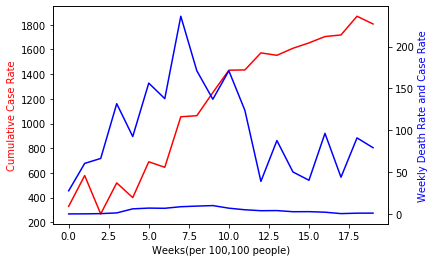

In [30]:

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.set_ylabel('Cumulative Case Rate', color='red')
ax_left.set_xlabel('Weeks(per 100,100 people)', color='black')
ax_right.set_ylabel('Weekly Death Rate and Case Rate', color='blue')
ax_left.plot(cumupredictions, color='red')
ax_right.plot(deathpredictions, color='blue')
ax_right.plot(casepredictions, color='blue')


### 4. Clustering Chicago into three danger levels

In [31]:
recent=data2.loc[data2['Week Number']==data2['Week Number'].max()]
recent.head()

,ZIP Code,Week Number,Week Start,Week End,Cases - Weekly,Cases - Cumulative,Case Rate - Weekly,Case Rate - Cumulative,Tests - Weekly,Tests - Cumulative,...,Test Rate - Cumulative,Percent Tested Positive - Weekly,Percent Tested Positive - Cumulative,Deaths - Weekly,Deaths - Cumulative,Death Rate - Weekly,Death Rate - Cumulative,Population,Row ID,ZIP Code Location
43,60612,47,11/15/2020,11/21/2020,236.0,1882.0,688.0,5485.1,2417.0,27487,...,80111.3,0.1,0.1,2,35,5.8,102.0,34311,60612-47,POINT (-87.687011 41.88004)
60,60617,47,11/15/2020,11/21/2020,429.0,4330.0,520.0,5246.3,2733.0,43888,...,53175.7,0.2,0.1,2,94,2.4,113.9,82534,60617-47,POINT (-87.556897 41.721257)
61,60618,47,11/15/2020,11/21/2020,375.0,4390.0,397.0,4650.7,3580.0,59592,...,63130.5,0.1,0.1,2,68,2.1,72.0,94395,60618-47,POINT (-87.703343 41.946699)
66,60619,47,11/15/2020,11/21/2020,208.0,2401.0,340.0,3919.5,1682.0,33172,...,54151.3,0.1,0.1,1,77,1.6,125.7,61258,60619-47,POINT (-87.60569 41.744737)
70,60621,47,11/15/2020,11/21/2020,97.0,1222.0,334.0,4207.7,766.0,14603,...,50282.3,0.1,0.1,0,55,0.0,189.4,29042,60621-47,POINT (-87.638812 41.776931)


In [32]:
Y = pd.DataFrame(recent['Percent Tested Positive - Weekly'])
Y['Case Rate - Cumulative'] = recent['Case Rate - Weekly']
Y['Death Rate - Weekly'] = recent['Death Rate - Weekly']
Y['Case Rate - Cumulative']=recent['Case Rate - Cumulative']
Y=Y.fillna(0)

In [33]:
scaler = StandardScaler()
scaler.fit(Y)
Y_scaled = scaler.transform(Y)

In [34]:
clustering = KMeans(n_clusters=3,init='random',max_iter=10,random_state=0).fit(Y_scaled)
clusters = clustering.labels_
silhouette_coefficient = metrics.silhouette_score(Y_scaled, clusters, metric = "euclidean")
print( silhouette_coefficient)


0.3193636431167058


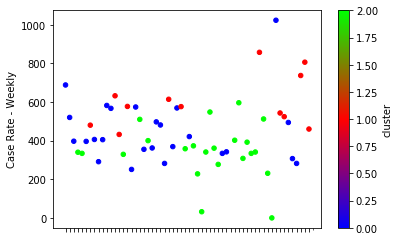

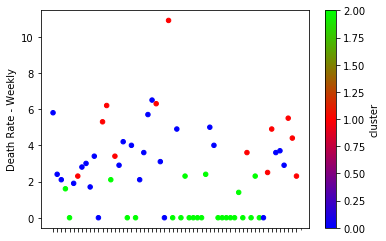

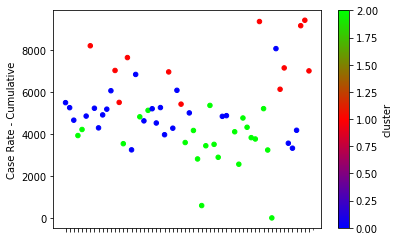

In [35]:
plotlevel(clusters)

1 represents high risk, 0 represents middle risk, 2 represents low risk

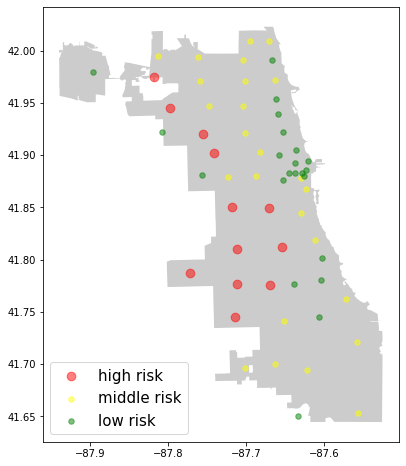

In [36]:
plotmap(recent,1,0,2)

In [37]:
clustering = linkage(Y_scaled, method='complete', metric='euclidean')
clusters = fcluster(clustering, 3, criterion = 'maxclust')
silhouette_coefficient = metrics.silhouette_score(Y_scaled, clusters, metric = "euclidean")
print( silhouette_coefficient)
recent["cluster"]= clusters

0.38253979967127333


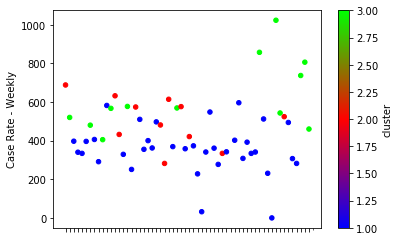

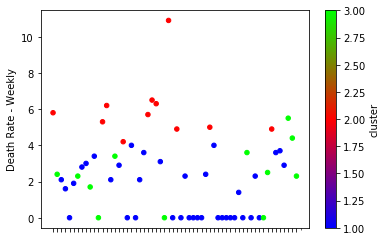

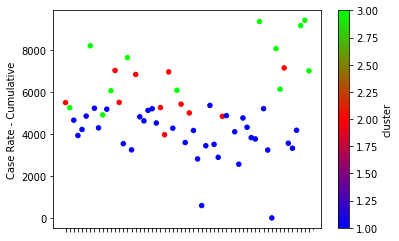

In [38]:
plotlevel(clusters)

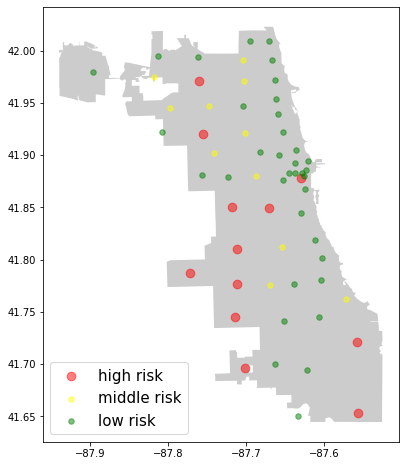

In [39]:
plotmap(recent,3,2,1)

0.4540348400360318


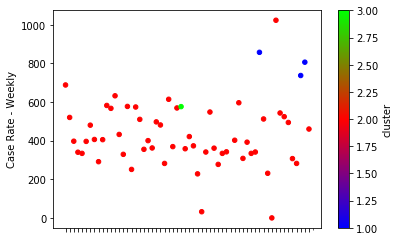

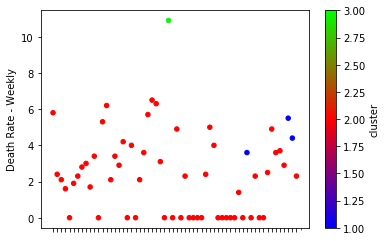

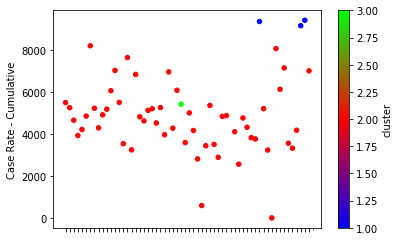

In [40]:
clustering = linkage(Y_scaled, method='single', metric='euclidean')
clusters = fcluster(clustering, 3, criterion = 'maxclust')
silhouette_coefficient = metrics.silhouette_score(Y_scaled, clusters, metric = "euclidean")
print( silhouette_coefficient)
recent["cluster"]= clusters
plotlevel(clusters)

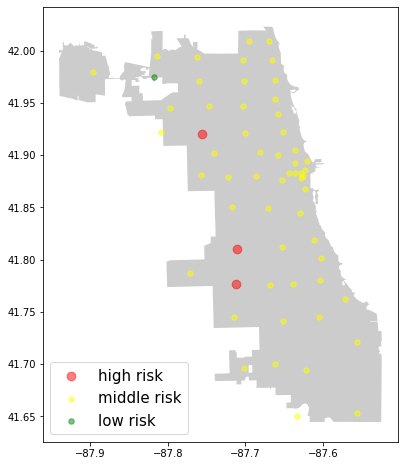

In [41]:
plotmap(recent,1,2,3)

Area near downtown are always low risks, suburbs are high risks